In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.colors import TwoSlopeNorm
import regionmask
import pandas as pd
from matplotlib import colors


In [3]:
# --- Open datasets ---
ds_pr  = xr.open_dataset("regressions_yearly_precip.nc")                     # precipitation regressions
ds_vp  = xr.open_dataset("regressions_yearly_velo_pot.nc") * 1e-6    # velocity potential regressions

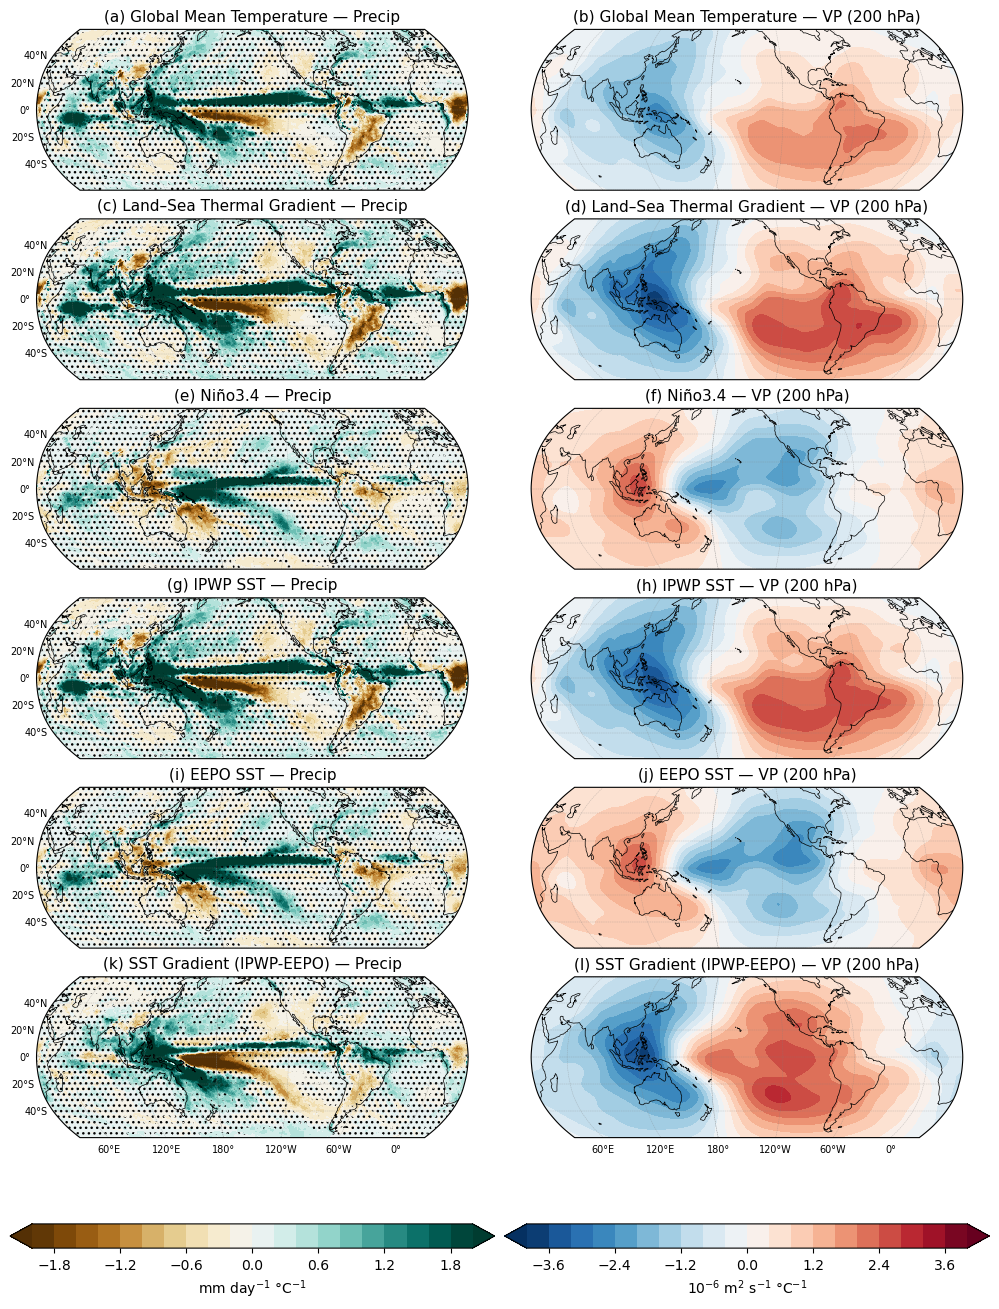

In [8]:


# --- Predictors to plot (order matters) and titles per row ---
predictors = ["GlobalMeanT", "LandSeaGradient", "Nino34", "WPO", "EPO", "WPO_EPO"]
row_titles = ["Global Mean Temperature", "Land–Sea Thermal Gradient",
              "Niño3.4", "IPWP SST", "EEPO SST", "SST Gradient (IPWP-EEPO)"]

# --- Helper: pick var names regardless of *_trend_* vs *_original_* ---
def pick_name(ds, base_suffix, kind="slope"):
    if kind == "slope":
        cand = [f"slope_era_trend_{base_suffix}"]
    elif kind == "pval":
        cand = [f"pval_era_trend_{base_suffix}"]
    else:
        raise ValueError("kind must be 'slope' or 'pval'")
    for name in cand:
        if name in ds.variables:
            return name
    raise KeyError(f"No variable found in dataset for {kind} with suffix '{base_suffix}'. Tried: {cand}")

# --- Coordinates (assumed lat/lon) ---
lat = ds_pr["lat"]
lon = ds_pr["lon"]

# --- Limits (keep as in your existing plots) ---
vlim_pr = (-2, 2)     # mm/day per °C
vlim_vp = (-4, 4)     # 10^-6 m^2 s^-1 per °C

# --- Projections ---
proj = ccrs.Robinson(central_longitude=210)
pc   = ccrs.PlateCarree()

nrows = len(predictors)

# --- Figure: 6 rows × 2 cols ---
fig, axes = plt.subplots(nrows, 2, figsize=(10, 13),
                         subplot_kw={"projection": proj},
                         constrained_layout=True)

# Keep latest mappables for column-shared colorbars
im_left, im_right = None, None

for r, pred in enumerate(predictors):
    # Select & slice latitude band
    
    sl_pr  = ds_pr[pick_name(ds_pr, pred, "slope")].sel(lat=slice(60, -60))
    pv_pr  = ds_pr[pick_name(ds_pr, pred, "pval")].sel(lat=slice(60, -60))
    sl_vp  = ds_vp[pick_name(ds_vp, pred, "slope")].sel(lat=slice(60, -60))
    pv_vp  = ds_vp[pick_name(ds_vp, pred, "pval")].sel(lat=slice(60, -60))

    lats = sl_pr["lat"].values
    lons = sl_pr["lon"].values

    # --- LEFT: Precip ---
    axL = axes[r, 0]
    im_left = axL.contourf(
        lons, lats, sl_pr.values,
        levels=np.linspace(vlim_pr[0], vlim_pr[1], 21),
        cmap="BrBG", extend="both", transform=pc
    )
    # Hatch p>=0.10
    maskL = (pv_pr.values >= 0.10) & (~np.isnan(pv_pr.values))
    axL.contourf(lons, lats, maskL, levels=[0.5, 1.5],
                 hatches=["..."], colors="none", transform=pc)
    axL.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=0.5)
    axL.set_title(f"({chr(97 + 2*r)}) {row_titles[r]} — Precip", fontsize=11, pad=6)

    # --- RIGHT: Velocity potential ---
    axR = axes[r, 1]
    im_right = axR.contourf(
        lons, lats, sl_vp.values,
        levels=np.linspace(vlim_vp[0], vlim_vp[1], 21),
        cmap="RdBu_r", extend="both", transform=pc
    )
    maskR = (pv_vp.values >= 0.10) & (~np.isnan(pv_vp.values))
    axR.contourf(lons, lats, maskR, levels=[0.5, 1.5],
                 hatches=["..."], colors="none", transform=pc)
    axR.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=0.5)
    axR.set_title(f"({chr(98 + 2*r)}) {row_titles[r]} — VP (200 hPa)", fontsize=11, pad=6)

# --- Gridlines (labels only left column + bottom row) ---
for r in range(nrows):
    for c in range(2):
        ax = axes[r, c]
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray",
                          alpha=0.5, linestyle="--")
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = (r == nrows - 1)
        gl.left_labels = (c == 0)
        gl.xlabel_style = {"size": 7}
        gl.ylabel_style = {"size": 7}

# --- Shared colorbars: one for each column ---
cbarL = fig.colorbar(im_left,  ax=[axes[r,0] for r in range(nrows)], orientation="horizontal",
                     fraction=0.04, pad=0.06)
cbarL.set_label("mm day$^{-1}$ °C$^{-1}$", fontsize=10)

cbarR = fig.colorbar(im_right, ax=[axes[r,1] for r in range(nrows)], orientation="horizontal",
                     fraction=0.04, pad=0.06)
cbarR.set_label(r"$10^{-6}$ m$^{2}$ s$^{-1}$ °C$^{-1}$", fontsize=10)

plt.savefig("./Figures/Figure_4.png", dpi=600, bbox_inches="tight")
plt.show()
